In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5

true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
def init_params():
    w = torch.normal(0, 0.01, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [5]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

In [6]:
def train(lambd, penalty):
    w, b = init_params()
    net, loss = lambda X:d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 200, 0.003
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print(f'w\'s L2 norm: {torch.norm(w).item():.3f}')

w's L2 norm: 0.146


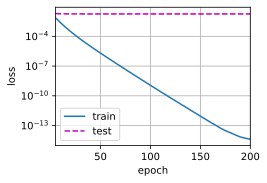

In [7]:
train(lambd=0, penalty=l2_penalty)

w's L2 norm: 0.132


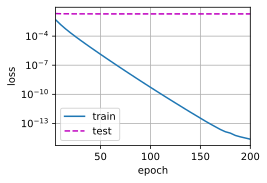

In [8]:
train(0, penalty=l1_penalty)

w's L2 norm: 0.032


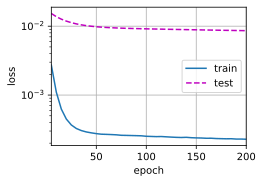

In [9]:
train(lambd=2, penalty=l2_penalty)

w's L2 norm: 0.239


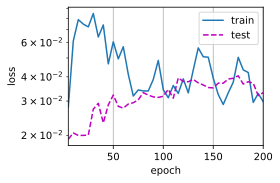

In [10]:
train(lambd=10, penalty=l1_penalty)

In [11]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 200, 0.003
    trainer = torch.optim.SGD([{'params': net[0].weight, 
                                'weight_decay': wd},
                                {'params': net[0].bias}], lr=lr)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))

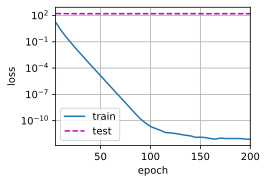

In [12]:
train_concise(wd=0)

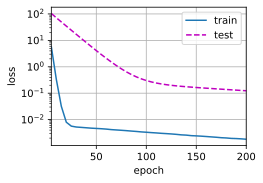

In [13]:
train_concise(wd=3)

In [ ]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1 - dropout)

In [44]:
X = torch.arange(16, dtype=torch.float32).reshape((2,8))
X, dropout_layer(X, 0.), dropout_layer(X, 0.5), dropout_layer(X, 1.)

(tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11., 12., 13., 14., 15.]]),
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11., 12., 13., 14., 15.]]),
 tensor([[ 0.,  2.,  4.,  6.,  0.,  0.,  0., 14.],
         [16.,  0., 20.,  0.,  0., 26.,  0., 30.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]))

In [45]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_hiddens1, num_hiddens2, num_outputs,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.is_training = is_training
        self.linear1 = nn.Linear(num_inputs, num_hiddens1)
        self.linear2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.linear3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.linear1(X.reshape((-1, self.num_inputs))))
        if self.is_training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.linear2(H1))
        if self.is_training:
            H2 = dropout_layer(H2, dropout2)
        out = self.linear3(H2)
        return out

net = Net(num_inputs, num_hiddens1, num_hiddens2, num_outputs)

In [47]:
def evaluate_accuracy(net, data_iter):
    """Evaluate the accuracy of the model on the dataset."""
    if isinstance(net, torch.nn.Module):
        # Use the model's evaluation mode to disable gradient calculation
        net.eval()
    metric = d2l.Accumulator(2)  # Correct predictions, total predictions
    for X, y in data_iter:
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]  # Return the accuracy

In [48]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """Train the model for one epoch."""
    if isinstance(net, torch.nn.Module):
        net.train()  # Set the model to training mode
    metric = d2l.Accumulator(3)  # Loss, correct predictions, total predictions
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()  # Update parameters
            metric.add(
                float(l) * len(y),
                d2l.accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # If updater is a custom function, then l would be a tensor
            l.sum().backward()
            updater(X.shape[0])  # Update parameters, shape[0] is the batch size
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]  # Return loss and accuracy

In [49]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],ylim=[0, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

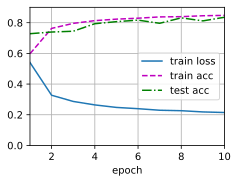

In [50]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [51]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(dropout1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(dropout2),
    nn.Linear(num_hiddens2, num_outputs)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

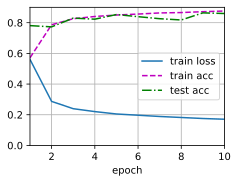

In [52]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)